## Purpose of Notebook

- Last update: 28 Jun 2021

Study *Local Outlier factor*

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

from sklearn.datasets import make_moons,\
                             make_blobs,\
                             samples_generator,\
                             make_friedman1
from sklearn.neighbors import LocalOutlierFactor

### Generate dataset

In [34]:
# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

rng = np.random.RandomState(42)

In [3]:
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)]

In [4]:
lof = LocalOutlierFactor(n_neighbors=30, contamination= outliers_fraction)

In [46]:
X_w_outlier = np.concatenate([datasets[0], rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)
y_pred = lof.fit_predict(X_w_outlier)

In [59]:
((y_pred>0) == (lof.negative_outlier_factor_ > -2.7)).sum()

298

(array([  1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   1.,   2.,   4.,   1.,   1.,   1.,   3.,
          3.,   4.,   3.,   3.,   1.,   2.,   4.,   2.,   3.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          7.,   3.,  14.,  28.,  51., 153.]),
 array([-8.22056428, -8.07532489, -7.9300855 , -7.78484611, -7.63960672,
        -7.49436733, -7.34912794, -7.20388855, -7.05864916, -6.91340977,
        -6.76817039, -6.622931  , -6.47769161, -6.33245222, -6.18721283,
        -6.04197344, -5.89673405, -5.75149466, -5.60625527, -5.46101588,
        -5.31577649, -5.1705371 , -5.02529771, -4.88005832, -4.73481893,
        -4.58957955, -4.44434016, -4.29910077, -4.15386138, -4.00862199,
        -3.8633826 , -3.71814321, -3.57290382, -3.42766443, -3.28242504,
        -3.13718565, -2.99194626, -2.84670687, -2.70146748, -2.55622809,
        -2.4109887 , -2.26574932, -2.12050993, -1.97527054, -1.83003115,
 

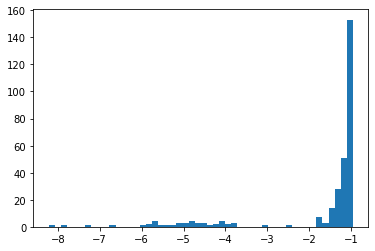

In [61]:
pl.hist(lof.negative_outlier_factor_, bins=50)

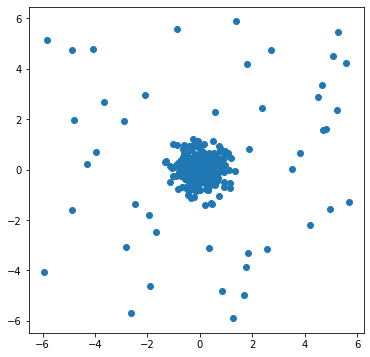

In [63]:
pl.figure(figsize=(6,6))
pl.scatter(X_w_outlier[:,0], X_w_outlier[:,1])

In [75]:
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

rng = np.random.RandomState(42)

blobs_params = dict(random_state=0, 
                    n_samples=n_inliers, 
                    n_features=2)
X, y = make_blobs(centers=[[0, 0], [0, 0]], 
                       cluster_std=0.5,
                       **blobs_params)

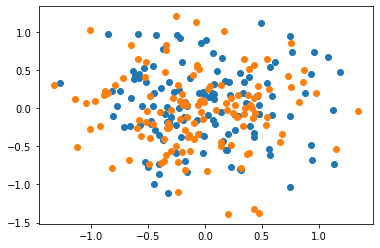

In [77]:
pl.scatter(X[y==0,0], X[y==0,1])
pl.scatter(X[y==1,0], X[y==1,1])

In [78]:
X, y = make_blobs(centers=[[-1, -1], [1, 1]], 
                       cluster_std=0.5,
                       **blobs_params)

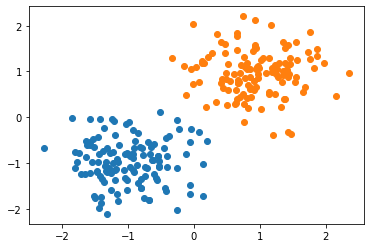

In [79]:
pl.scatter(X[y==0,0], X[y==0,1])
pl.scatter(X[y==1,0], X[y==1,1])

### Toy Dataset

Toy dataset consists of three possible patitions: (i) inlier (ii) outlier (iii) novelty. The goal is to build a high performance model on inlier either by removing outliers from dataset before training any model or giving less weight to them while training a model. The novelty handling process would be different. One approach could be to isolate them into a seperate clusters and build a model just on the inliers or have a more general model that can incorporate both inliers and novelty.

The data-generator consists of exactly three equvalent generators: (i)`inlier_generator`, (ii) `outlier_generator` and finally (iii) `novelty_generator`. Since the main topic of this work is price estimation and it is a supervised problem, it demands generation of both features and target. In *class* `DataGenerator` we considered two type of features:
1. Numeric
2. Categorical
Numeric features are generated by a single or multivariate Gaussian process and Categorical features (e.g. type, material) are generated with integer generateor (what is the underlying process?). The target can be any conditional and algebric function of features depending on the complexity of the problem. To make the target more general, we define $N$-order polynomial of combination of numerical target and sum of step function for categorical features. 

To make it clear, let us take an $X$ matrix with $M$ number of features and $N$ number of datapoints. To generate a target of 
$$ y = f(X) = f(x1, x2, \ldots, x_M)$$
with degree of $l$ we would have
$$ y = a_1 x_1 + \ldots + a_M x_M + \ldots + a^2_1 x_1 x_2 + \ldots a^l_1 x_1 x_2 \ldots x_M $$
that many coeficients $a_i^j$ can be zero. To mimic dataset that generated with a real ... add some step (quantization , step function ) to the coefficient.

In [32]:
def make_target_independent(X, degrees=1, coeffs=None):
    """ Generate target for given numerical features."""
    y = np.zeros(X.shape[0])
    
    for dg in range(degrees):
        indxs = np.random.choice(X.shape[1], dg)
        coefs = np.random.randint(1, 4, size=len(indxs))
        for c, indx in zip(coefs, indxs):
            y += c*X[:,indx]
    return y

In [33]:
N_features = 5
N_datapoints = 100
X = np.random.rand(N_datapoints, N_features)

In [34]:
y = make_target_independent(X, 3)

In [35]:
import seaborn as sns

In [41]:
df = pd.DataFrame(X, columns=[f'x{i}' for i in range(1,6)])
df['y'] = y

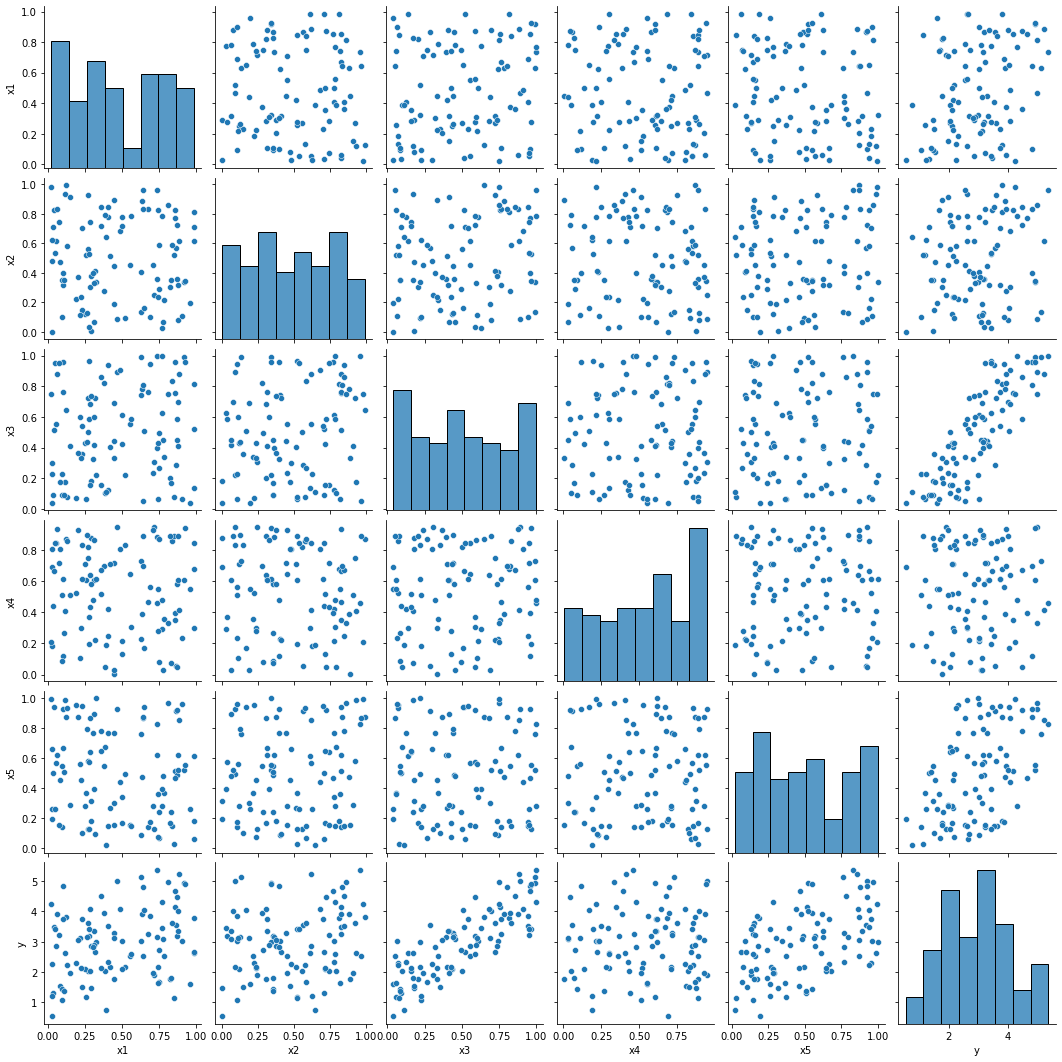

In [42]:
sns.pairplot(df)